In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split

# seed so random stuff isnt random
SEED = 100

# eurosat class names
class_names = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
    'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
    'River', 'SeaLake'
]

In [25]:
# load dataset with same transforms as training (but without augmentation)
# we use imagenet normalization for convnext
test_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# load full dataset
dataset = torchvision.datasets.EuroSAT(root='./data', download=True, transform=test_transform)

# split into train, test with same seed as training
# 80% train, 20% test 
train_ratio = 0.8
test_ratio = 0.2

total_size = len(dataset)
train_size = int(total_size * train_ratio)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"train: {len(train_dataset)}")
print(f"test size: {len(test_dataset)}")

train: 21600
test size: 5400


In [26]:
# load model architecture
model = models.convnext_large(weights=None)

# replace classifier head with 10 outputs
num_ftrs = model.classifier[2].in_features
model.classifier[2] = torch.nn.Linear(num_ftrs, 10)

# load checkpoint
checkpoint_path = 'checkpoints/train_7_20251120_021513/model_epoch_580.pt'
model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print(f"model loaded from: {checkpoint_path}")
print(f"device: {device}")

/tmp/ipykernel_2344/3456438088.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))


model loaded from: checkpoints/train_7_20251120_021513/model_epoch_580.pt
device: cuda


In [27]:
# evaluate model on test set and collect predictions
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=128, 
    shuffle=False
)

all_predictions = []
all_labels = []
all_images = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_images.extend(images.cpu())


all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# calculate accuracy
correct = (all_predictions == all_labels).sum()
total = len(all_labels)
accuracy = 100 * correct / total

print(f"\ntest accuracy: {accuracy:.2f}%")
print(f"correct: {correct}/{total}")


test accuracy: 97.22%
correct: 5250/5400


In [28]:
# find indices of correct and incorrect predictions
correct_indices = np.where(all_predictions == all_labels)[0]
incorrect_indices = np.where(all_predictions != all_labels)[0]

print(f"correct predictions: {len(correct_indices)}")
print(f"incorrect predictions: {len(incorrect_indices)}")

# organize failures by class
failures_by_class = {}
for idx in incorrect_indices:
    true_label = all_labels[idx]
    pred_label = all_predictions[idx]
    
    if true_label not in failures_by_class:
        failures_by_class[true_label] = []
    
    failures_by_class[true_label].append({
        'idx': idx,
        'predicted': pred_label
    })


correct predictions: 5250
incorrect predictions: 150


In [29]:
# helper function to denormalize images for display
def denormalize(tensor):
    # reverse imagenet normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    img = tensor * std + mean
    img = torch.clamp(img, 0, 1)
    return img.permute(1, 2, 0).numpy()

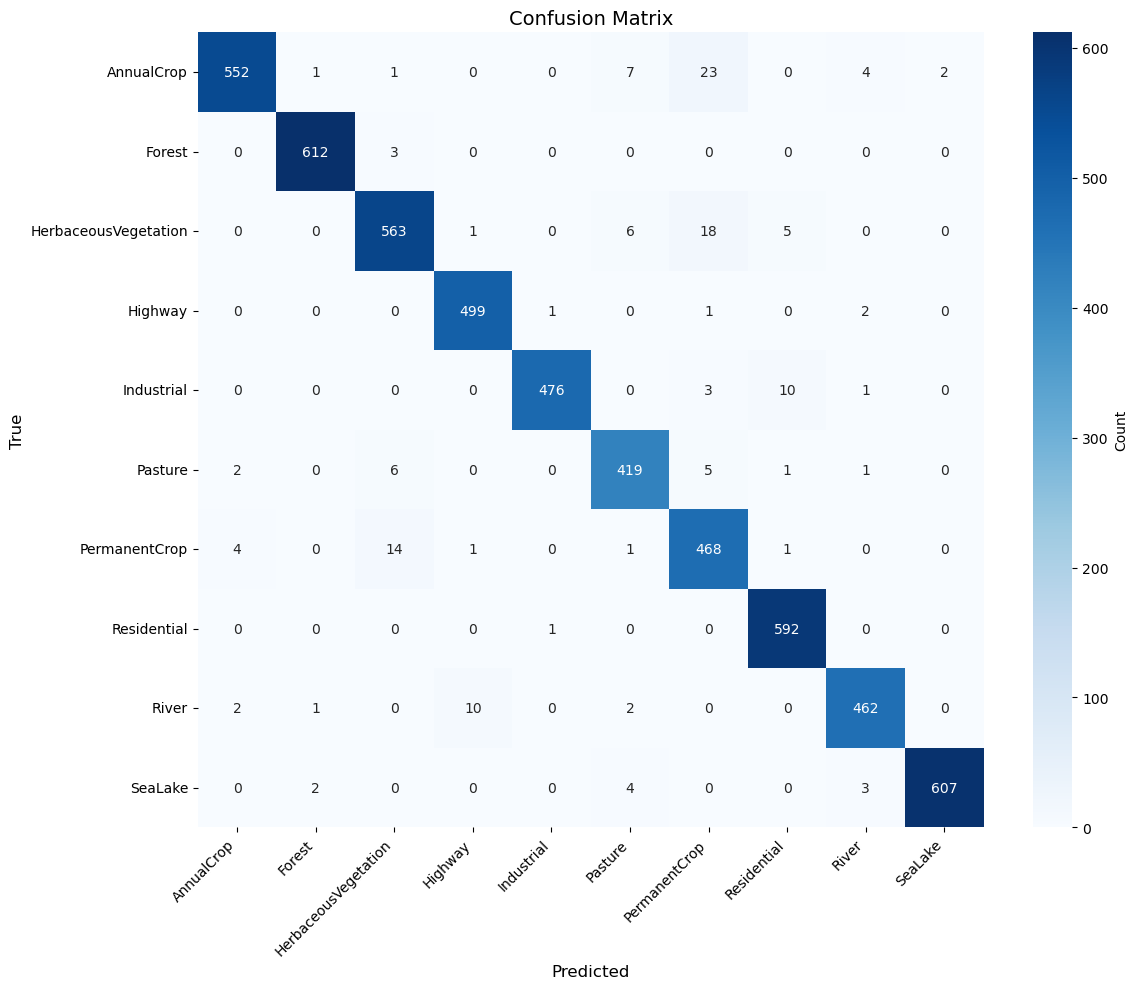

confusion matrix saved to results/confusion_matrix.png


In [30]:
# compute confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_predictions)

# plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('True', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("confusion matrix saved to results/confusion_matrix.png")

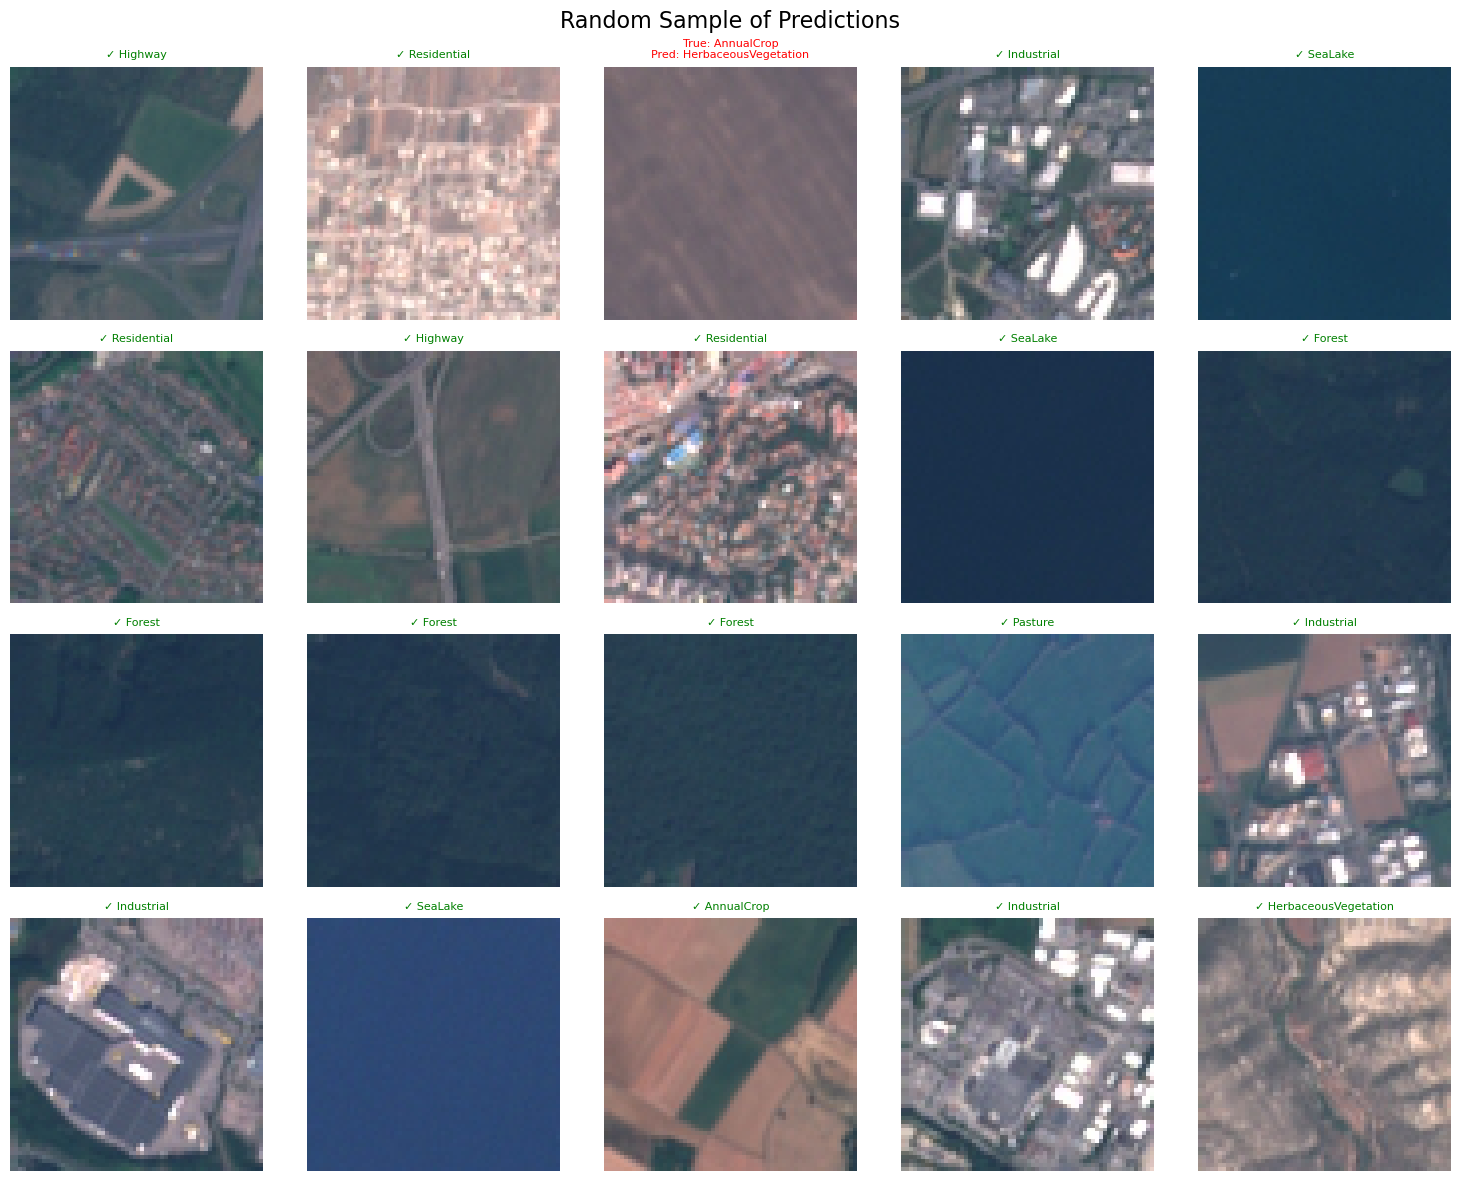

random predictions visualization saved to results/random_predictions.png


In [31]:
# show random sample of predictions (mix of correct and incorrect)
num_samples = 20
sample_indices = np.random.choice(len(all_labels), num_samples, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Random Sample of Predictions', fontsize=16)

for i, idx in enumerate(sample_indices):
    row = i // 5
    col = i % 5
    
    img = denormalize(all_images[idx])
    true_label = all_labels[idx]
    pred_label = all_predictions[idx]
    
    axes[row, col].imshow(img)
    
    if true_label == pred_label:
        # correct prediction
        title_color = 'green'
        title = f"✓ {class_names[pred_label]}"
    else:
        # incorrect prediction
        title_color = 'red'
        title = f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}"
    
    axes[row, col].set_title(title, fontsize=8, color=title_color)
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('results/random_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("random predictions visualization saved to results/random_predictions.png")